In [1]:
!pip install transformers datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# 2. Load Dataset

In [5]:

# Pastikan file data.csv sudah ada di Colab (upload file atau mount Google Drive)
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/Image Classification/data.csv")
print("Shape dataset:", df.shape)
print(df.head())

Shape dataset: (871, 7)
  AnimalName symptoms1             symptoms2 symptoms3    symptoms4  \
0        Dog     Fever              Diarrhea  Vomiting  Weight loss   
1        Dog     Fever              Diarrhea  Coughing    Tiredness   
2        Dog     Fever              Diarrhea  Coughing     Vomiting   
3        Dog     Fever  Difficulty breathing  Coughing     Lethargy   
4        Dog     Fever              Diarrhea  Coughing     Lethargy   

     symptoms5 Dangerous  
0  Dehydration       Yes  
1        Pains       Yes  
2     Anorexia       Yes  
3     Sneezing       Yes  
4     Blue Eye       Yes  



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AnimalName  871 non-null    object
 1   symptoms1   871 non-null    object
 2   symptoms2   871 non-null    object
 3   symptoms3   871 non-null    object
 4   symptoms4   871 non-null    object
 5   symptoms5   871 non-null    object
 6   Dangerous   869 non-null    object
dtypes: object(7)
memory usage: 47.8+ KB
None

Statistik deskriptif:
       AnimalName symptoms1 symptoms2 symptoms3    symptoms4 symptoms5  \
count         871       871       871       871          871       871   
unique         46       232       230       229          217       203   
top     Buffaloes     Fever  Diarrhea  Coughing  Weight loss     Pains   
freq          129       257       119        95          117        99   

       Dangerous  
count        869  
unique         2  
top          Yes  
freq 

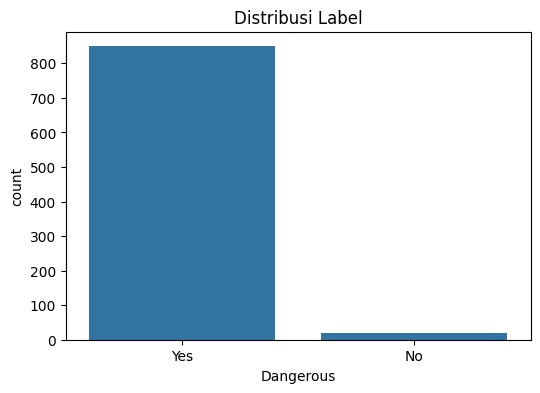


Contoh data setelah preprocessing:
                                                text  Dangerous
0  Dog Fever Diarrhea Vomiting Weight loss Dehydr...          1
1        Dog Fever Diarrhea Coughing Tiredness Pains          1
2      Dog Fever Diarrhea Coughing Vomiting Anorexia          1
3  Dog Fever Difficulty breathing Coughing Lethar...          1
4      Dog Fever Diarrhea Coughing Lethargy Blue Eye          1


<ipython-input-7-b3e324b0c709>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})
<ipython-input-7-b3e324b0c709>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['AnimalName'] + " " + df['symptoms1'] + " " + df['symptoms2'] + " " + df['symptoms3'] + " " + df['symptoms4'] + " " + df['symptoms5']


In [7]:
# 3. Exploratory Data Analysis (EDA)
print("\nInfo dataset:")
print(df.info())

print("\nStatistik deskriptif:")
print(df.describe())

print("\nJumlah nilai null per kolom:")
print(df.isnull().sum())

# Visualisasi distribusi label (gunakan kolom 'Dangerous')
plt.figure(figsize=(6,4))
sns.countplot(x='Dangerous', data=df)
plt.title("Distribusi Label")
plt.show()

# 4. Preprocessing
# Menghapus baris dengan nilai null pada kolom target 'Dangerous'
df = df.dropna(subset=['Dangerous'])

# Konversi label kategori 'Yes' dan 'No' menjadi numerik
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})

# 5. Menggabungkan teks dari beberapa kolom menjadi satu
df['text'] = df['AnimalName'] + " " + df['symptoms1'] + " " + df['symptoms2'] + " " + df['symptoms3'] + " " + df['symptoms4'] + " " + df['symptoms5']

# Pastikan hanya menyimpan kolom yang relevan
df = df[['text', 'Dangerous']]

print("\nContoh data setelah preprocessing:")
print(df.head())

In [8]:
# 6. Split Data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Dangerous'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Dangerous'])

print("Ukuran train:", train_df.shape)
print("Ukuran validasi:", val_df.shape)
print("Ukuran test:", test_df.shape)

Ukuran train: (608, 2)
Ukuran validasi: (130, 2)
Ukuran test: (131, 2)


In [9]:
# 7. Load Model & Tokenizer (Menggunakan Pre-trained BERT)
model_name = "bert-base-uncased"  # Bisa diganti dengan model lain (misalnya IndoBERT untuk bahasa Indonesia)
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 8. Persiapkan Dataset untuk Training (Hugging Face Datasets)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenisasi teks
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Konversi dataset ke format tensor PyTorch
columns_to_keep = ['input_ids', 'attention_mask', 'Dangerous']
train_dataset.set_format(type='torch', columns=columns_to_keep, output_all_columns=True)
val_dataset.set_format(type='torch', columns=columns_to_keep, output_all_columns=True)
test_dataset.set_format(type='torch', columns=columns_to_keep, output_all_columns=True)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Training Model

In [14]:
import os

# 1. Pastikan WandB tidak mengganggu training
os.environ["WANDB_DISABLED"] = "true"

# 2. Ganti nama kolom target menjadi `labels`
train_dataset = train_dataset.rename_column("Dangerous", "labels")
val_dataset = val_dataset.rename_column("Dangerous", "labels")
test_dataset = test_dataset.rename_column("Dangerous", "labels")

# 3. Perbaiki TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",  # Perbaiki warning evaluation_strategy → eval_strategy
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",  # Perbaiki WandB warning: report_to="none"
    seed=42
)

# 4. Buat Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 5. Mulai Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.037200,0.129864,0.976923,0.954379,0.976923,0.965519
2,0.073100,0.059289,0.992308,0.992368,0.992308,0.991554
3,0.035600,0.052771,0.992308,0.992368,0.992308,0.991554


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=114, training_loss=0.10101604540097087, metrics={'train_runtime': 76.2941, 'train_samples_per_second': 23.907, 'train_steps_per_second': 1.494, 'total_flos': 119978641244160.0, 'train_loss': 0.10101604540097087, 'epoch': 3.0})


Classification Report pada Data Validasi:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.99      1.00      1.00       127

    accuracy                           0.99       130
   macro avg       1.00      0.83      0.90       130
weighted avg       0.99      0.99      0.99       130



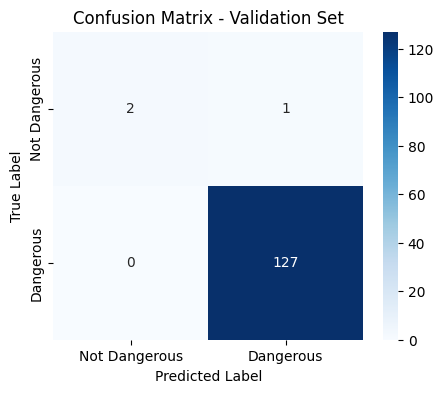

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 10. Evaluasi Model pada Data Validasi
val_predictions_output = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions_output.predictions, axis=-1)

# Mengambil label sebenarnya dari dataset validasi
true_labels = val_df['Dangerous'].values

# Menampilkan Classification Report
print("\nClassification Report pada Data Validasi:")
print(classification_report(true_labels, val_preds))

# Menampilkan Confusion Matrix
cm = confusion_matrix(true_labels, val_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Dangerous', 'Dangerous'], yticklabels=['Not Dangerous', 'Dangerous'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [17]:
from transformers import pipeline

# Buat pipeline untuk klasifikasi teks
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Contoh hewan baru dengan gejala tertentu
new_samples = [
    {"AnimalName": "Wolf", "symptoms": "Fever, Aggressive Behavior, Red Eyes, Heavy Breathing, Bite Wounds"},
    {"AnimalName": "Rabbit", "symptoms": "Sneezing, Runny Nose, Watery Eyes, Loss of Appetite, Lethargy"},
    {"AnimalName": "Snake", "symptoms": "Venomous Bite, Swelling, Paralysis, Severe Pain, Bleeding"},
    {"AnimalName": "Eagle", "symptoms": "Weakness, Feather Loss, Vision Problems, Trouble Flying, Noisy Breathing"},
]

print("\n🔍 **Prediksi Model pada Sample Baru:**")
for sample in new_samples:
    prediction = classifier(sample["symptoms"])
    label = prediction[0]['label']
    score = prediction[0]['score']
    print(f"🦁 Hewan: {sample['AnimalName']} | 🔬 Gejala: {sample['symptoms']}")
    print(f"➡️ **Prediksi Model:** {'BERBAHAYA' if label == 'LABEL_1' else 'TIDAK BERBAHAYA'} (Confidence: {score:.2f})\n")

Device set to use cuda:0



🔍 **Prediksi Model pada Sample Baru:**
🦁 Hewan: Wolf | 🔬 Gejala: Fever, Aggressive Behavior, Red Eyes, Heavy Breathing, Bite Wounds
➡️ **Prediksi Model:** BERBAHAYA (Confidence: 1.00)

🦁 Hewan: Rabbit | 🔬 Gejala: Sneezing, Runny Nose, Watery Eyes, Loss of Appetite, Lethargy
➡️ **Prediksi Model:** BERBAHAYA (Confidence: 1.00)

🦁 Hewan: Snake | 🔬 Gejala: Venomous Bite, Swelling, Paralysis, Severe Pain, Bleeding
➡️ **Prediksi Model:** BERBAHAYA (Confidence: 1.00)

🦁 Hewan: Eagle | 🔬 Gejala: Weakness, Feather Loss, Vision Problems, Trouble Flying, Noisy Breathing
➡️ **Prediksi Model:** BERBAHAYA (Confidence: 1.00)



In [19]:
import os

# Tentukan folder untuk menyimpan model
model_dir = "/content/sample_data/model"

# Pastikan direktori tersedia
os.makedirs(model_dir, exist_ok=True)

# Simpan model dan tokenizer
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

print(f"Model dan tokenizer telah disimpan di: {model_dir}")

Model dan tokenizer telah disimpan di: /content/sample_data/model
